### Import delle librerie necessarie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import recall_score, precision_score,RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import Ridge, Lasso
# Encoding delle variabili
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
def preprocess_categorical_feature(df, column_name, threshold=0.1):
    """
    Preprocessa variabili categoriche raggruppando le classi rare.
    
    Parametri:
    - df: DataFrame originale
    - column_name: nome della colonna da preprocessare
    - threshold: percentuale minima per considerare una categoria 'significativa'
    
    Restituisce:
    - DataFrame con colonna categorica preprocessata
    """
    # Converti la colonna in stringa per garantire uniformità
    df[column_name] = df[column_name].astype(str)
    
    # Calcola la distribuzione delle categorie
    value_counts = df[column_name].value_counts(normalize=True)
    
    # Identifica le categorie rare (sotto la soglia)
    rare_categories = value_counts[value_counts < threshold].index.tolist()
    
    # Crea una nuova colonna mappando le categorie rare in 'Other'
    df[f'{column_name}_grouped'] = df[column_name].apply(
        lambda x: 'Other' if x in rare_categories else x
    )
    
    return df

### Import del dataset tramite URL

In [3]:
CSV_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv"
df_bck = pd.read_csv(CSV_URL, index_col = "id")

In [4]:
df = df_bck.copy()

In [5]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### Verifica il numero di righe e colonne nel dataset

In [6]:
df.shape

(381109, 11)

### Verifica la tipologia di ogni variabile

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


In [8]:
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


### Verifica il numero di valori mancanti per ogni colonna

In [9]:
df.count()

Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

### Controllo e rimozione duplicati

In [10]:
# Trova duplicati
duplicati = df[df.duplicated()]

# Rimuovi duplicati
df = df.drop_duplicates()

In [11]:
df.count()

Gender                  380840
Age                     380840
Driving_License         380840
Region_Code             380840
Previously_Insured      380840
Vehicle_Age             380840
Vehicle_Damage          380840
Annual_Premium          380840
Policy_Sales_Channel    380840
Vintage                 380840
Response                380840
dtype: int64

### Costruisco una matrice di correlazione

C:\Users\dniko\AppData\Local\Temp\ipykernel_27932\2076903947.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  hm = sns.heatmap(df.corr(),


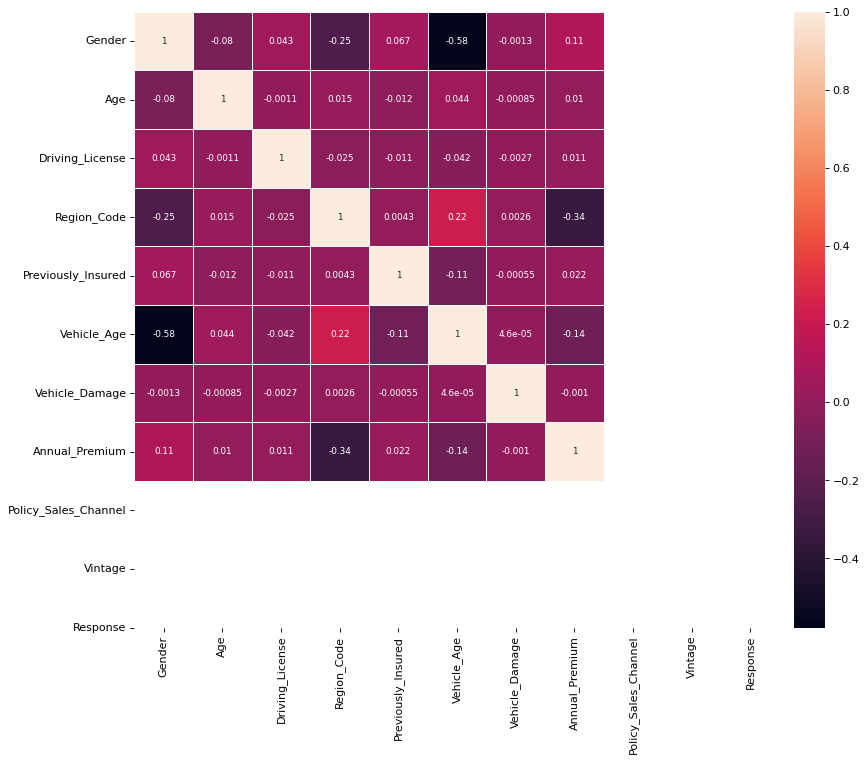

In [12]:
plt.figure(figsize=(14, 10), dpi=80)

hm = sns.heatmap(df.corr(),
                 cbar=True,
                 square=True,
                 yticklabels=df.columns,
                 xticklabels=df.columns,
                 annot=True,                
                 annot_kws={'size':8},
                 fmt='.2g',
                linewidth = .5)    

plt.show()

La matrice di correlazione ci indica che le variabili maggiormente correlate alla variabile "Response", risultano essere le variabili "Previously_Insured", "Vehicle_Age", "Vehicle_Damage". Mostrano anche una bassa correlazione anche le variabili "Age" e "Policy_Sales_Channel"

### Distribuzione della variabile "Response"

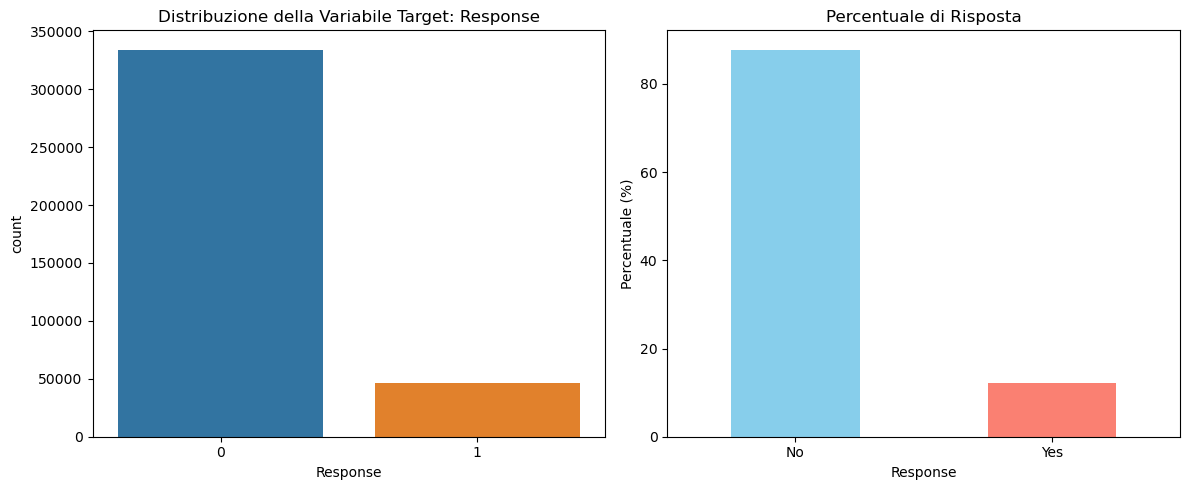

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

sns.countplot(x='Response', data=df, ax=axes[0]) 
axes[0].set_title('Distribuzione della Variabile Target: Response')

response_percentage = df['Response'].value_counts(normalize=True) * 100
response_percentage.plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[1])  # Assegniamo il secondo subplot
axes[1].set_title('Percentuale di Risposta')
axes[1].set_xlabel('Response')
axes[1].set_ylabel('Percentuale (%)')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No', 'Yes'], rotation=0)


plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()

il grafico mostra un non bilanciamento della variabile "Response" con più del 80% degli utenti con risposta no rispetto alla risposta Yes

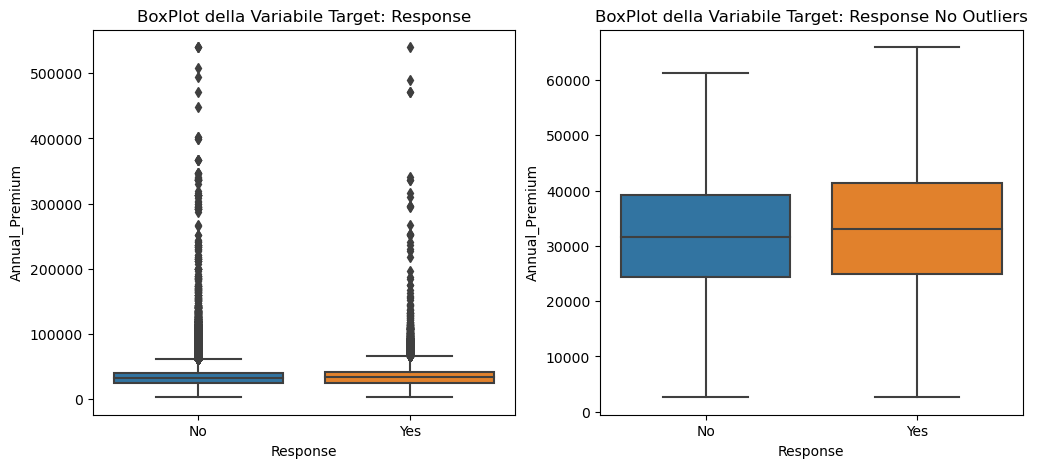

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
sns.boxplot(x='Response', y='Annual_Premium', data=df, ax = axes[0])
axes[0].set_title('BoxPlot della Variabile Target: Response')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)
sns.boxplot(x='Response', y='Annual_Premium', data=df, ax = axes[1], showfliers =False)
axes[1].set_title('BoxPlot della Variabile Target: Response No Outliers')
axes[1].set_xticklabels(['No', 'Yes'], rotation=0)
plt.show()

I grafici presentano la distribuzione della variabile Annual_Premium per risposta. A sinistra con la presenza degli outliers e a destra senza la presenza di questi ultimi, esclusi dalla rappresentazione grafica, solo per individuare meglio la distribuzione. Si può notare una distribuzione simile tra i due BoxPlot, con una variabilità maggiore per il premio annuale con Risposta "Yes" e con una mediana più alta.

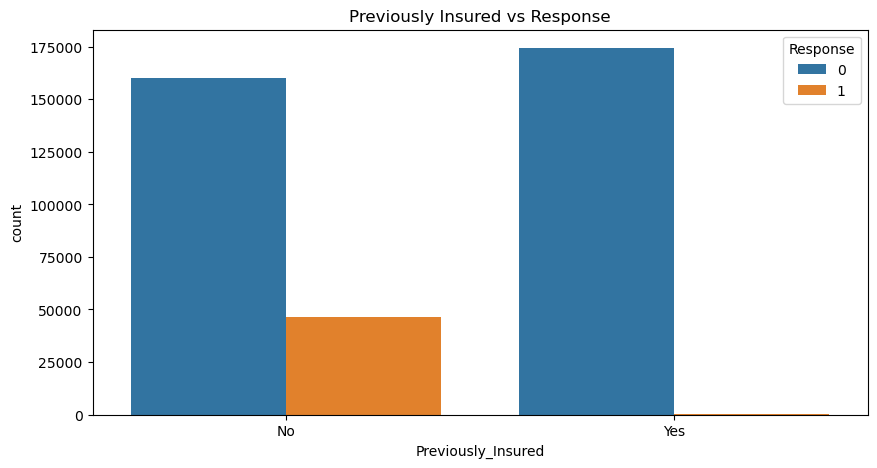

In [15]:
# Correct code for creating the figure and axes
fig, ax = plt.subplots(figsize=(10, 5))  # Use plt.subplots() to create figure and axes
sns.countplot(x='Previously_Insured', hue='Response', data=df)
ax.set_xticklabels(['No', 'Yes'], rotation=0)
plt.title('Previously Insured vs Response')
plt.show()

Il grafico mostra il numero di utenti precedentemente assicurati per risposta. Si osserva come gli utenti precedentemente non assicurati siano più tendenti ad una risposta positiva.

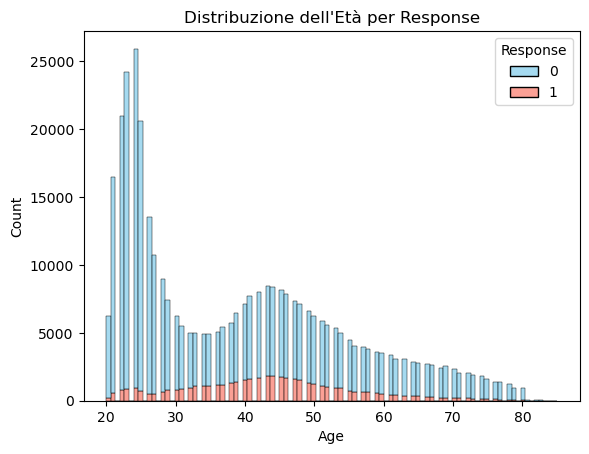

In [16]:
sns.histplot(data=df, x='Age', hue='Response', multiple='stack', palette=['skyblue', 'salmon'])
plt.title('Distribuzione dell\'Età per Response')
plt.show()

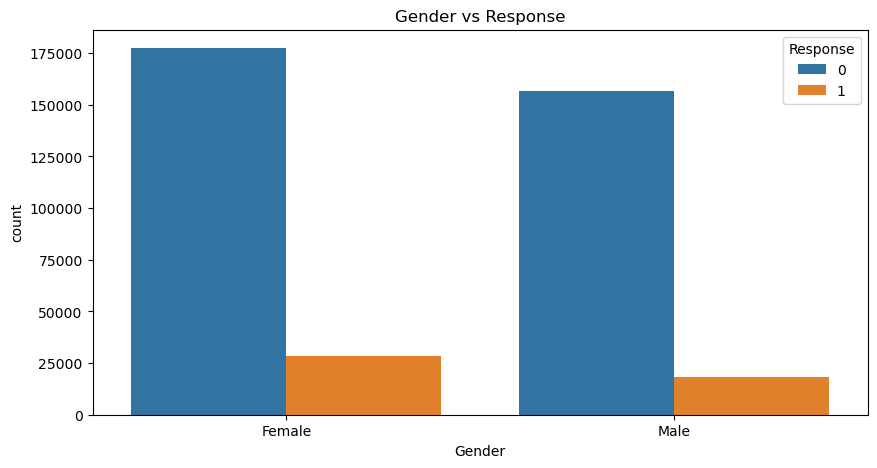

In [17]:
# Correct code for creating the figure and axes
fig, ax = plt.subplots(figsize=(10, 5))  # Use plt.subplots() to create figure and axes
sns.countplot(x='Gender', hue='Response', data=df)
ax.set_xticklabels(['Female', 'Male'], rotation=0)
plt.title('Gender vs Response')
plt.show()

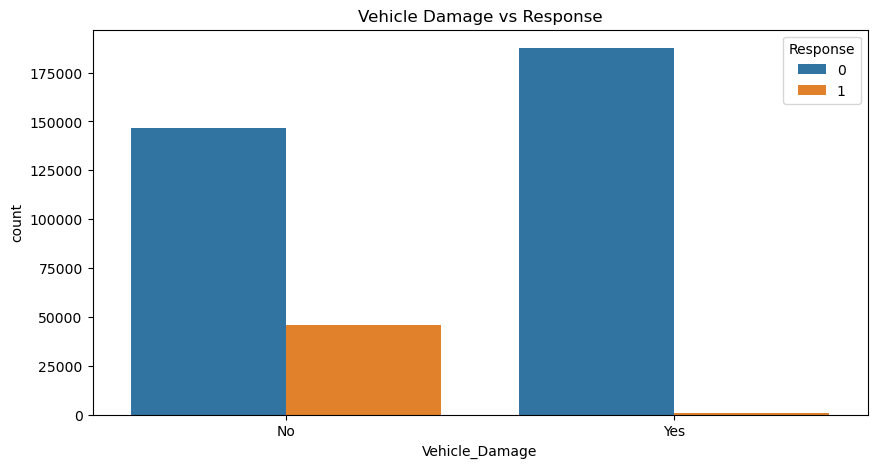

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))  # Use plt.subplots() to create figure and axes
sns.countplot(x='Vehicle_Damage', hue='Response', data=df)
plt.title('Vehicle Damage vs Response')
ax.set_xticklabels(['No', 'Yes'], rotation=0)
plt.show()

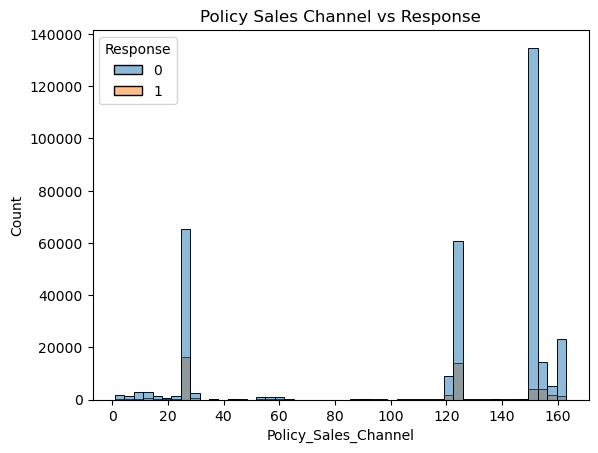

In [19]:
sns.histplot(x='Policy_Sales_Channel', hue='Response', data=df)
plt.title('Policy Sales Channel vs Response')
plt.show()

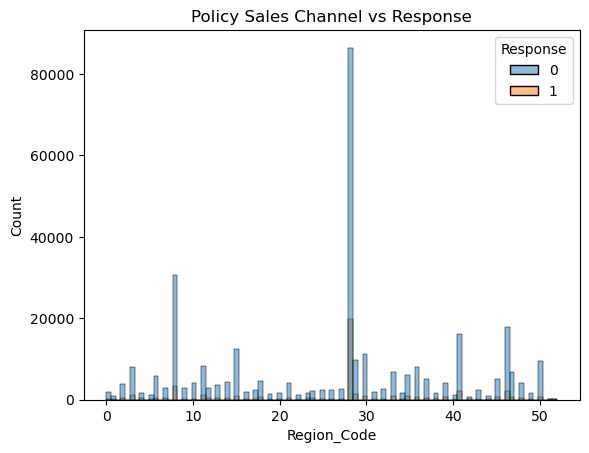

In [20]:
sns.histplot(x='Region_Code', hue='Response', data=df)
plt.title('Policy Sales Channel vs Response')
plt.show()

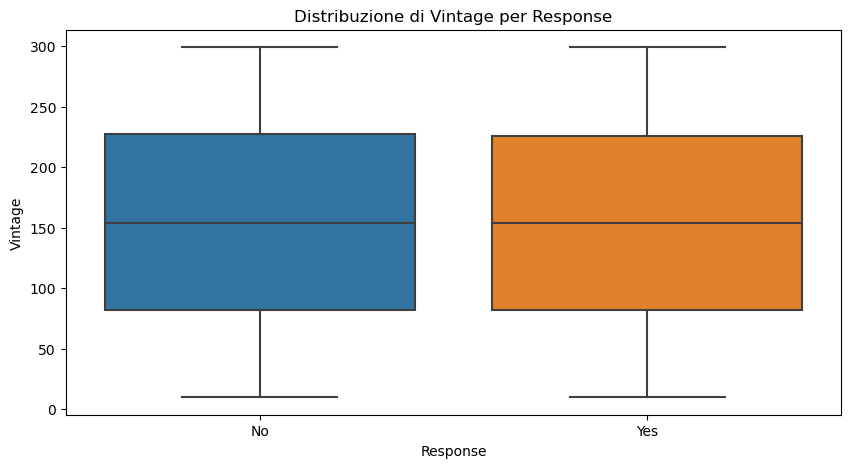

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))  # Use plt.subplots() to create figure and axes
sns.boxplot(x='Response', y='Vintage', data=df)
plt.title('Distribuzione di Vintage per Response')
ax.set_xticklabels(['No', 'Yes'], rotation=0)
plt.show()

### Divido il dataset in X e y, dove y è la variabile "Response" e X è costituito da tutte le altre variabili da utilizzare per l'addestramento del modello di ML

In [22]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

print(X)
print(y)

[['Male' 44 1 ... 40454.0 26.0 217]
 ['Male' 76 1 ... 33536.0 26.0 183]
 ['Male' 47 1 ... 38294.0 26.0 27]
 ...
 ['Male' 21 1 ... 35118.0 160.0 161]
 ['Female' 68 1 ... 44617.0 124.0 74]
 ['Male' 46 1 ... 41777.0 26.0 237]]
[1 0 1 ... 0 0 0]


## Gestione dello sbilanciamento

In [23]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = dict(zip(np.unique(y), class_weights))
print(weight_dict)

{0: 0.5698553066690608, 1: 4.078826175431081}


In [24]:
# Preprocessing delle variabili categoriche
df = preprocess_categorical_feature(df, 'Region_Code')
df = preprocess_categorical_feature(df, 'Policy_Sales_Channel')

# Encoding delle variabili categoriche originali
le = LabelEncoder()
df["Vehicle_Age"] = le.fit_transform(df["Vehicle_Age"].astype(str))
df["Vehicle_Damage"] = le.fit_transform(df["Vehicle_Damage"].astype(str))
df["Gender"] = le.fit_transform(df["Gender"].astype(str))

# Preparazione del preprocessore
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
         ['Region_Code_grouped', 'Policy_Sales_Channel_grouped'])
    ],
    remainder='passthrough'
)

# Preparazione dei dati per il modello
X = df.drop('Response', axis=1)
y = df['Response']

# Applicazione del preprocessore
X_transformed = preprocessor.fit_transform(X)

### Suddivisione del dataset in train e test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=.2, random_state=0, stratify=y)

In [26]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Implemento il modello di regressione logistica

In [27]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### Valutazione del modello

In [28]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]
    
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_roc_auc = roc_auc_score(y_train, y_proba_train)
    
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_proba_test)
    
    print(f"TRAIN Accuracy: {train_accuracy:.2f}")
    print(f"TRAIN F1 Score: {train_f1:.2f}")
    print(f"TRAIN ROC AUC: {train_roc_auc:.2f}")
    
    print(f"TEST Accuracy: {test_accuracy:.2f}")
    print(f"TEST F1 Score: {test_f1:.2f}")
    print(f"TEST ROC AUC: {test_roc_auc:.2f}")
    
    print("\nTEST REPORT")
    print(classification_report(y_test, y_pred_test))
    
    print("\nConfusion Matrix - Training Set")
    plot_confusion_matrix(y_train, y_pred_train)
    
    print("\nConfusion Matrix - Test Set")
    plot_confusion_matrix(y_test, y_pred_test)

def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=True):
    cm = confusion_matrix(y_true, y_pred)  # tn, fp, fn, tp

    df_cm = pd.DataFrame(cm, index=labels,
                         columns=["Predicted " + labels[0], "Predicted " + labels[1]])
    sns.heatmap(df_cm, annot=True, fmt='g')

    if show_precision_recall:
        precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
        recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
        plt.text(0, -0.1, f"Precision: {precision:.3f}")
        plt.text(1, -0.1, f"Recall: {recall:.3f}")
    plt.show()


Valutazione del modello:
TRAIN Accuracy: 0.65
TRAIN F1 Score: 0.40
TRAIN ROC AUC: 0.83
TEST Accuracy: 0.65
TEST F1 Score: 0.40
TEST ROC AUC: 0.84

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.60      0.75     66831
           1       0.25      0.97      0.40      9337

    accuracy                           0.65     76168
   macro avg       0.62      0.78      0.58     76168
weighted avg       0.90      0.65      0.71     76168


Confusion Matrix - Training Set


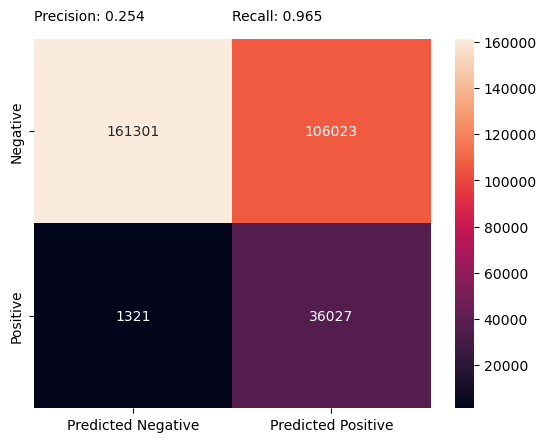


Confusion Matrix - Test Set


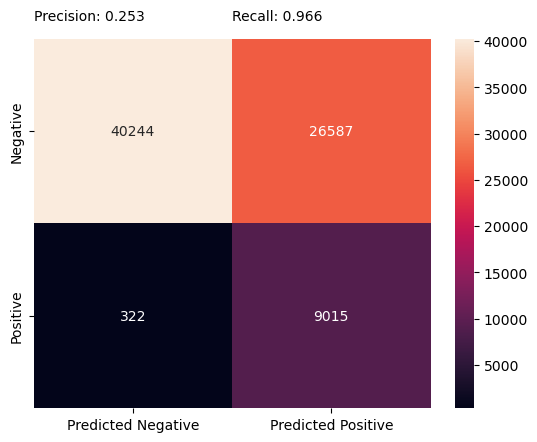

In [29]:
print("\nValutazione del modello:")
evaluate_model(lr, X_train, y_train, X_test, y_test)

### Regolarizzazione con Modello Ridge


Valutazione del modello Ridge:
TRAIN Accuracy: 0.88
TRAIN F1 Score: 0.00
TRAIN ROC AUC: 0.83
TEST Accuracy: 0.88
TEST F1 Score: 0.00
TEST ROC AUC: 0.84

TEST REPORT
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66831
           1       0.00      0.00      0.00      9337

    accuracy                           0.88     76168
   macro avg       0.44      0.50      0.47     76168
weighted avg       0.77      0.88      0.82     76168


Confusion Matrix - Training Set


C:\Users\dniko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dniko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dniko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

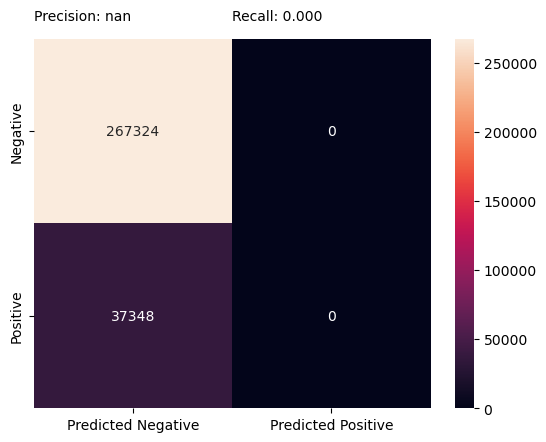


Confusion Matrix - Test Set


C:\Users\dniko\AppData\Local\Temp\ipykernel_27932\1654911321.py:43: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])


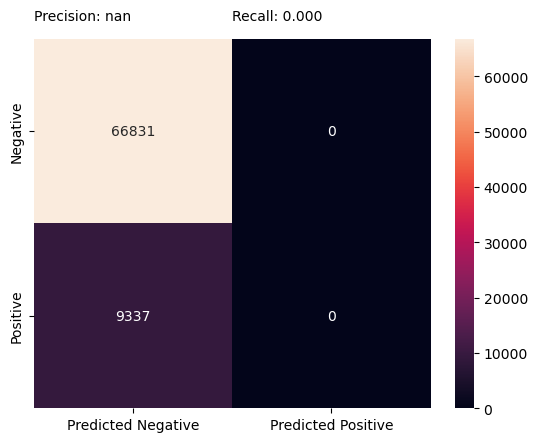

In [30]:
# Regressione Logistica Ridge (Penalizzazione L2)
ridge_model = LogisticRegression(penalty='l2', solver='liblinear')
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
print("\nValutazione del modello Ridge:")
evaluate_model(ridge_model, X_train, y_train, X_test, y_test)


Valutazione del modello Lasso:
TRAIN Accuracy: 0.88
TRAIN F1 Score: 0.00
TRAIN ROC AUC: 0.83
TEST Accuracy: 0.88
TEST F1 Score: 0.00
TEST ROC AUC: 0.84

TEST REPORT
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66831
           1       0.00      0.00      0.00      9337

    accuracy                           0.88     76168
   macro avg       0.44      0.50      0.47     76168
weighted avg       0.77      0.88      0.82     76168


Confusion Matrix - Training Set


C:\Users\dniko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dniko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dniko\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

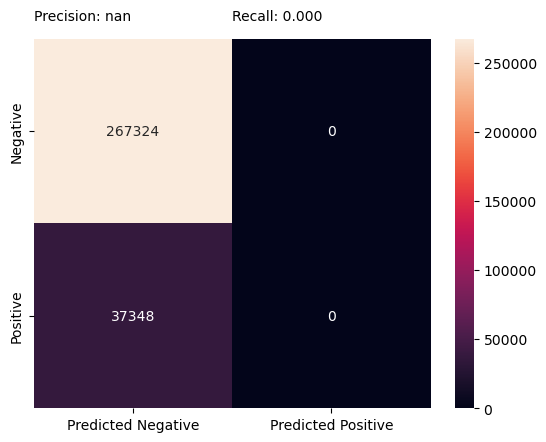


Confusion Matrix - Test Set


C:\Users\dniko\AppData\Local\Temp\ipykernel_27932\1654911321.py:43: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])


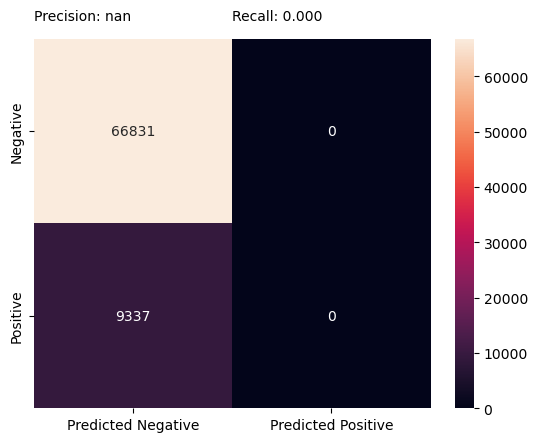

In [31]:
# Regressione Logistica Lasso
lasso_model = LogisticRegression(penalty='l1', solver='liblinear')
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)
print("\nValutazione del modello Lasso:")
evaluate_model(lasso_model, X_train, y_train, X_test, y_test)

### Riaddestro il modello sul training set con l'undersampling e l'oversampling

In [32]:
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
pipeline = Pipeline([('over', over), ('under', under)])
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [33]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced')


Valutazione del modello LR con Undersampling e Oversampling:
TRAIN Accuracy: 0.72
TRAIN F1 Score: 0.70
TRAIN ROC AUC: 0.83
TEST Accuracy: 0.65
TEST F1 Score: 0.40
TEST ROC AUC: 0.84

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.60      0.75     66831
           1       0.25      0.97      0.40      9337

    accuracy                           0.65     76168
   macro avg       0.62      0.78      0.58     76168
weighted avg       0.90      0.65      0.71     76168


Confusion Matrix - Training Set


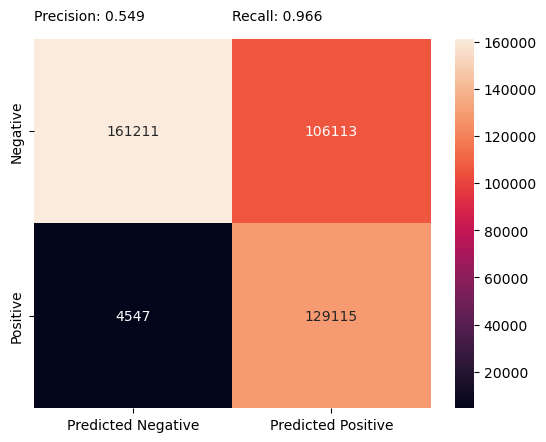


Confusion Matrix - Test Set


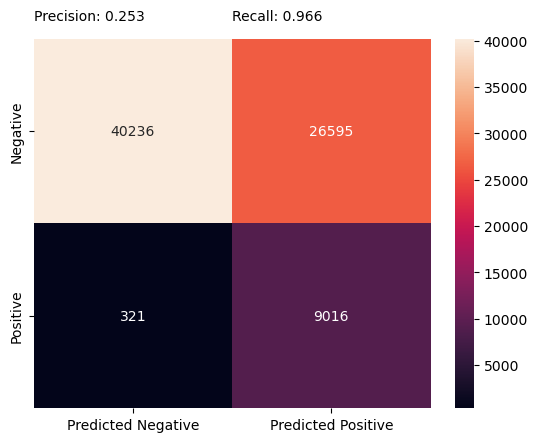

In [34]:
print("\nValutazione del modello LR con Undersampling e Oversampling:")
evaluate_model(lr, X_train_resampled, y_train_resampled, X_test, y_test)

Utilizzando i dati considerando undersampling e oversampling l'accuratezza migliora per il train set, ma resta di 0.64 per il test set.

Valutazione del modello Lasso:
TRAIN Accuracy: 0.75
TRAIN F1 Score: 0.68
TRAIN ROC AUC: 0.83
TEST Accuracy: 0.73
TEST F1 Score: 0.43
TEST ROC AUC: 0.84

TEST REPORT
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     66831
           1       0.29      0.81      0.43      9337

    accuracy                           0.73     76168
   macro avg       0.63      0.77      0.62     76168
weighted avg       0.88      0.73      0.78     76168


Confusion Matrix - Training Set


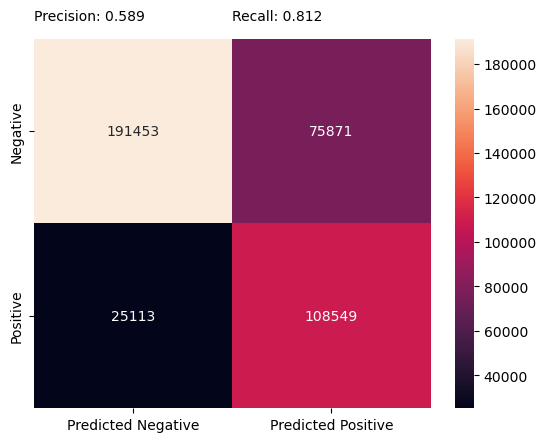


Confusion Matrix - Test Set


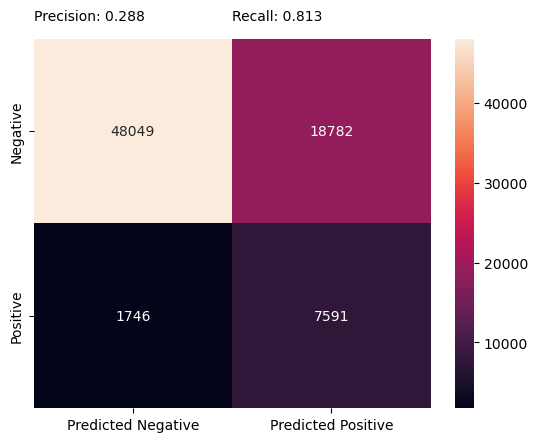

In [35]:
lasso_model = LogisticRegression(penalty='l1', solver='liblinear')
print("Valutazione del modello Lasso:")
evaluate_model(lasso_model, X_train_resampled, y_train_resampled, X_test, y_test)


Valutazione del modello Ridge:
TRAIN Accuracy: 0.75
TRAIN F1 Score: 0.68
TRAIN ROC AUC: 0.83
TEST Accuracy: 0.73
TEST F1 Score: 0.43
TEST ROC AUC: 0.84

TEST REPORT
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     66831
           1       0.29      0.81      0.43      9337

    accuracy                           0.73     76168
   macro avg       0.63      0.77      0.62     76168
weighted avg       0.88      0.73      0.78     76168


Confusion Matrix - Training Set


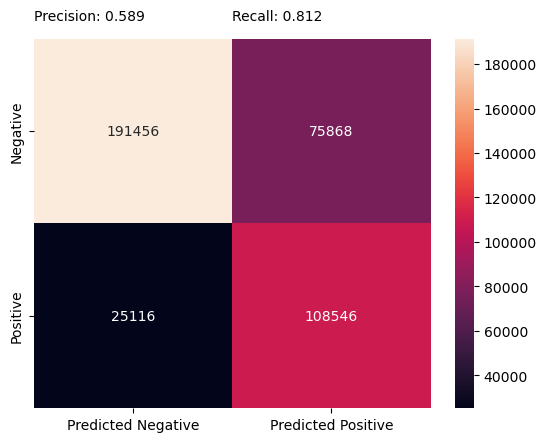


Confusion Matrix - Test Set


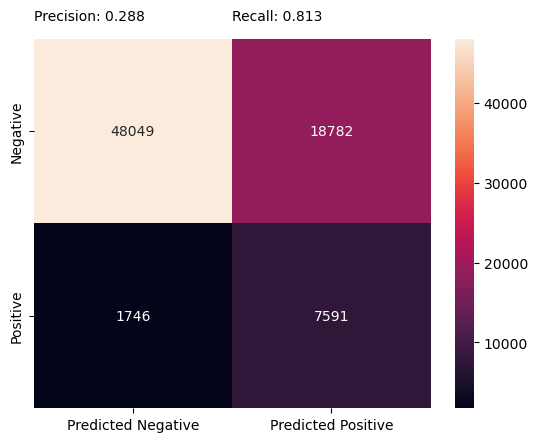

In [36]:
ridge_model = LogisticRegression(penalty='l2', solver='liblinear')
print("\nValutazione del modello Ridge:")
evaluate_model(ridge_model, X_train_resampled, y_train_resampled, X_test, y_test)

### Considerazioni

Il Modello di regressione logistica senza bilanciamento mostra un accuracy di 0.64 per entrambi i set di TRAIN e TEST indica che il modello ha difficoltà a distinguere correttamente tra le classi. Il ROC AUC di 0.83 mostra che il modello ha una buona capacità di discriminazione complessiva tra le classi, ma l'F1 score per la classe 1 è molto basso (0.40), indicando che il  modello non predice bene la classe 1.

I Modelli Ridge e Lasso senza bilanciamento, mostrano accuratezza molto alta (0.88), ma con un F1 score per la classe 1 di 0.00, il che significa che praticamente non riescono a identificare la classe 1, infatti il modello classifica quasi tutto come classe 0 (come indicato dalla precision perfetta per la classe 0), ignorando completamente la classe 1 (recall molto bassa per la classe 1). Il ROC AUC resta a 0.83.

Applicando tecniche di undersampling e oversampling si ha un miglioramento delle performance dei modelli, specialmente per la classe 1. Infatti, per la Regressione logistica con bilanciamento, l'accuracy non cambia molto (0.64), ma l'F1 score per la classe 1 sale a 0.40, e i punteggi di recall della classe 1 diventano molto alti (0.98), migliorando significativamente la capacità del modello di individuare la classe minoritaria.

I modelli Lasso e Ridge con bilanciamento mostrano un aumento dell'accuracy a 0.76 e l'F1 score per la classe 1 è migliorato (0.43), con una distribuzione più equilibrata della precision e recall. La classe 0 mantiene un buon livello di accuratezza, ma ora il modello è anche capace di predire la classe 1 con una recall di 0.73, anche se la precision è più bassa (0.30).

Prima dei bilanciamenti, sia la regressione logistica che Ridge e Lasso non riescono a gestire lo sbilanciamento e ignorano la classe 1. Dopo il bilanciamento, i modelli Ridge e Lasso performano meglio in termini di bilanciamento tra le classi, migliorando l'F1 score della classe 1 e la loro capacità di identificare correttamente la classe positiva.